# ARIMA Model Application: Forecasting Johnson & Johnson's Time Series Data

In [ ]:
# Import necessary libraries for time series analysis and visualization
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Data Preparation
# Load the dataset from a CSV file with date parsing
# The 'date' column will be converted into datetime format for time series analysis
data = pd.read_csv('jj (2).csv', parse_dates=['date'])

# Set 'date' as the index for time series data
data = data.set_index('date')

# Rename the column 'data' to 'Sales' for better clarity and understanding
data = data.rename(columns={'data': 'Sales'})

# Print the first few rows of the dataset to inspect the data
print(data.head())

# Print the shape of the dataset to check its dimensions (rows, columns)
print("Data shape:", data.shape)


            Sales
date             
1960-01-01   0.71
1960-04-01   0.63
1960-07-02   0.85
1960-10-01   0.44
1961-01-01   0.61
Data shape: (84, 1)


# Visualize the Johnson & Johnson Sales Dataset

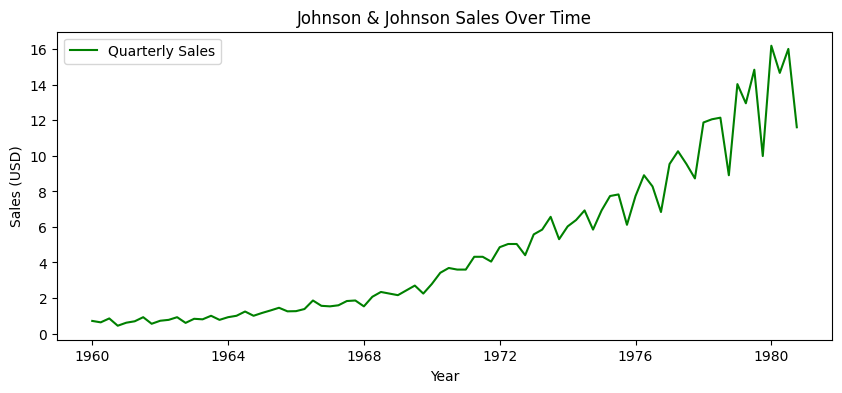

In [ ]:
# Visualize the Original Time Series

import matplotlib.pyplot as plt

# Create a figure with a specified size
plt.figure(figsize=(10,4))
# Plot the time series data: 'Sales' over time
# The x-axis represents the date index, and the y-axis represents the sales value
plt.plot(data.index, data['Sales'], color='green', label='Quarterly Sales')
plt.title('Johnson & Johnson Sales Over Time')
plt.xlabel('Year')
plt.ylabel('Sales (USD)')
plt.legend()
plt.show()


# Stationarity Augmented Dickey-Fuller Test(ADF)

In [ ]:
# Check for Stationarity (Augmented Dickey-Fuller Test)

from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Sales'])
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")


ADF Statistic: 2.742
p-value: 1.000


# Make the Series Stationary (Log Transform and Differencing)

In [ ]:
# Since Data is non-stationary (p>0.05)

# Apply Log transform the sales
log_sales = np.log(data['Sales'])

# Difference the log-transformed series
log_diff1 = log_sales.diff().dropna()

# ADF test on the differenced log series
result = adfuller(log_diff1)
print(f"ADF after 1st diff (log): {result[0]:.3f}")
print(f"p-value: {result[1]:.4f}")


ADF after 1st diff (log): -4.317
p-value: 0.0004


# ACF and PACF for the Stationary Series

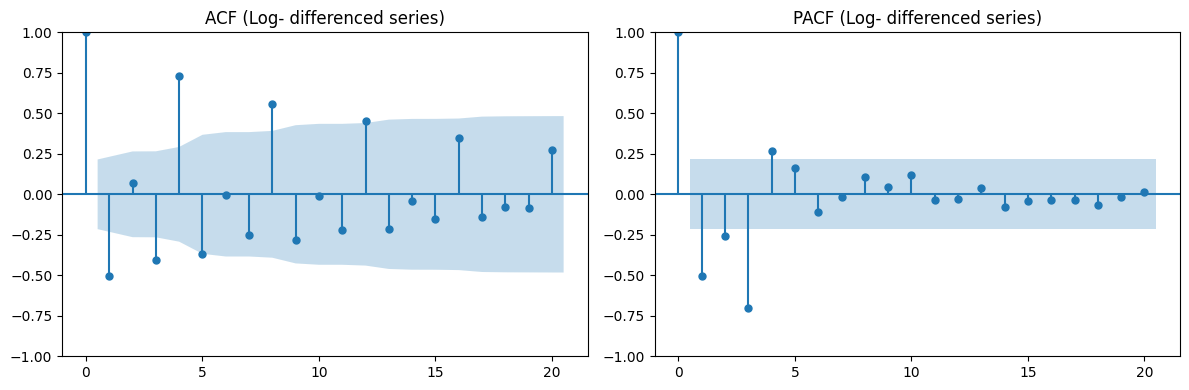

In [ ]:
# Now stationary(p<0.05)

# Plot ACF and PACF for the Stationary Series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(log_diff1, lags=20, ax=plt.gca(), title='ACF (Log- differenced series)')
plt.subplot(1,2,2)
plot_pacf(log_diff1, lags=20, ax=plt.gca(), title='PACF (Log- differenced series)')
plt.tight_layout()
plt.show()


# ARMA Model Fit (p,d,q)

In [ ]:
# Manual Search for the Best ARIMA(p,d,q) Model using AIC
# Find Best ARIMA Model (Loop over p=0-7,d=0-2,q=0-7)

import statsmodels.api as sm

def find_best_arima(data, p_range, d_range, q_range):
    """
    Function to determine the best ARIMA model based on AIC.

    Parameters:
    data (pd.Series): Time series data.
    p_range (int): Maximum number of AR (Auto-Regressive) terms to consider.
    d_range (int): Maximum number of differences allowed.
    q_range (int): Maximum number of MA (Moving Average) terms to consider.

    Returns:
    tuple: Best ARIMA model order and the corresponding AIC.
    """
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p in range(p_range):
        for d in range(d_range):
            for q in range(q_range):
                try:
                    model = sm.tsa.arima.ARIMA(data, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                        best_model = results
                except Exception as e:
                    print(f"Failed to fit ARIMA({p},{d},{q}): {str(e)}")
                    continue

    print(f"Best ARIMA order by AIC: {best_order}, AIC = {best_aic:.3f}")
    return best_order, best_aic, best_model


best_order, best_aic, best_model = find_best_arima(log_sales, 7, 2, 7)


Best ARIMA order by AIC: (4, 1, 3), AIC = -144.199


In [ ]:
# Fit the chosen ARIMA model
model = sm.tsa.arima.ARIMA(log_sales, order=(4, 1, 3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  80.099
Date:                Thu, 10 Apr 2025   AIC                           -144.199
Time:                        14:17:42   BIC                           -124.848
Sample:                             0   HQIC                          -136.425
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0004      0.060     -0.007      0.994      -0.118       0.117
ar.L2          0.0141      0.049      0.286      0.775      -0.082       0.111
ar.L3          0.0272      0.048      0.565      0.5

In [ ]:
# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale) and convert to original scale
predictions = model_fit.get_prediction(start=log_sales.index[0], dynamic=False)
predicted_log = predictions.predicted_mean
predicted_sales = np.exp(predicted_log)

# Align actual sales with predicted indices
actual_sales = data.loc[predicted_log.index, 'Sales']

# Calculate metrics
mae = mean_absolute_error(actual_sales, predicted_sales)
mse = mean_squared_error(actual_sales, predicted_sales)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_sales - predicted_sales) / actual_sales)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: 0.28
MSE: 0.16
RMSE: 0.40
MAPE: 8.21%


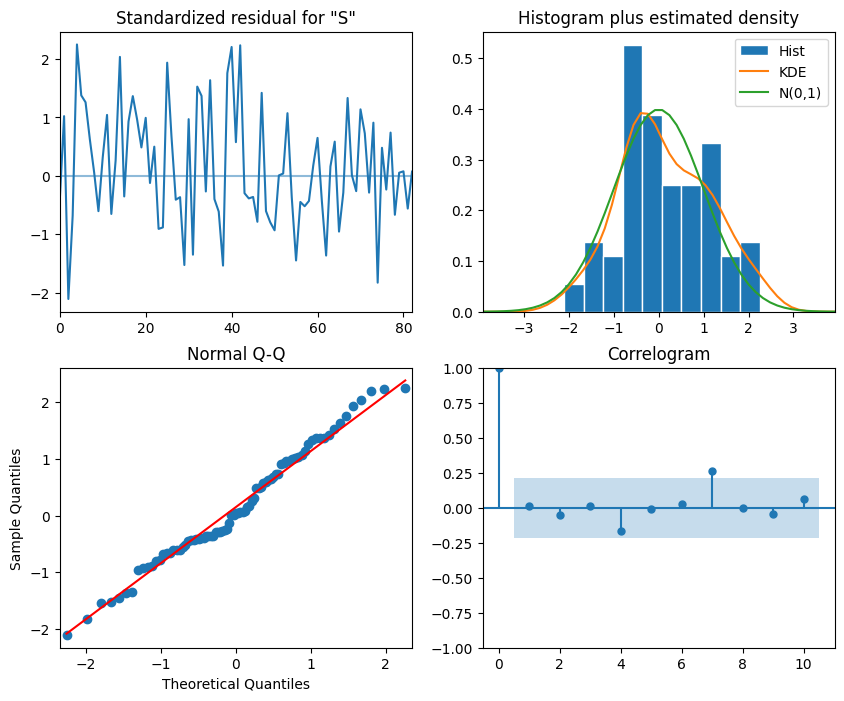

In [ ]:
# diagnostics plot
model_fit.plot_diagnostics(figsize=(10,8))
plt.show()


# Forecast the Next 24 Months (8 Quarters)

In [ ]:
# Forecast 8 steps ahead (8 quarters = 24 months)
n_steps = 8
forecast_result = model_fit.get_forecast(steps=n_steps)
# Predicted mean in log scale and its conf. interval
log_forecast = forecast_result.predicted_mean
log_conf_int = forecast_result.conf_int()

# Convert forecasts back to original scale
forecast = np.exp(log_forecast)
conf_int_lower = np.exp(log_conf_int['lower Sales'])
conf_int_upper = np.exp(log_conf_int['upper Sales'])

# Display the forecast values and confidence intervals
forecast.index = pd.date_range(start='1981-01-01', periods=n_steps, freq='Q')
print(forecast)
print(conf_int_lower)
print(conf_int_upper)


1981-03-31    18.041091
1981-06-30    16.652417
1981-09-30    18.006734
1981-12-31    13.455473
1982-03-31    20.330969
1982-06-30    18.817969
1982-09-30    20.208755
1982-12-31    15.529884
Freq: QE-DEC, Name: predicted_mean, dtype: float64
84    15.183948
85    13.882597
86    14.766287
87    11.007722
88    15.421601
89    14.103416
90    14.876963
91    11.364686
Name: lower Sales, dtype: float64
84    21.435858
85    19.974864
86    21.958295
87    16.447521
88    26.803202
89    25.108523
90    27.451422
91    21.221642
Name: upper Sales, dtype: float64


# JJ Sales Forecast for Next 8 Quarters(24 months)

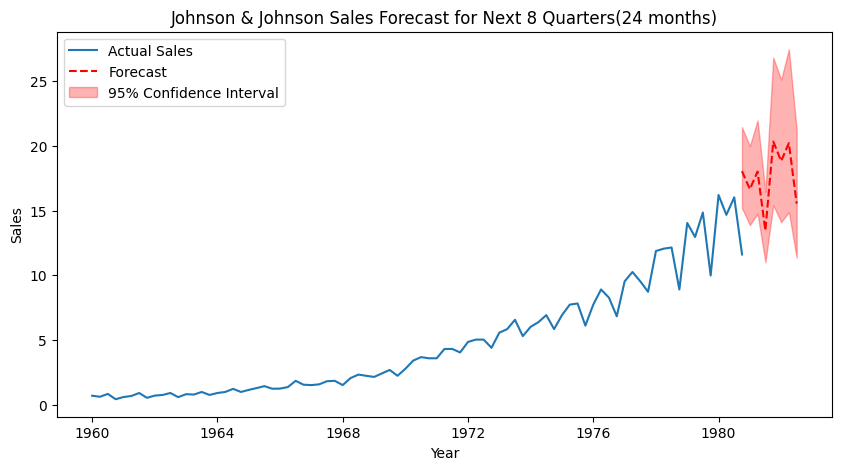

In [ ]:
# Plot the Forecast vs Original Series

# Prepare index for forecast periods
forecast_index = pd.date_range(start='1980-08-01', periods=8, freq='Q')
# Plot the original series and forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Sales'], label='Actual Sales')
plt.plot(forecast_index, forecast.values, label='Forecast', color='red', linestyle='--')
# Plot confidence interval as shaded area
plt.fill_between(forecast_index, conf_int_lower.values, conf_int_upper.values,
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.title('Johnson & Johnson Sales Forecast for Next 8 Quarters(24 months)')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.show()


# ARIMA Model Case Study ( Amazon Time Series Forecasting )

In [ ]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# If pmdarima is installed, import auto_arima
try:
    import pmdarima as pm
except ImportError:
    pm = None

# Data Preparation
# Load the dataset
df = pd.read_csv('AMZN (2).csv', parse_dates=['Date'], index_col='Date')
# Examine the first few rows
print(df[['Close']].head())

# Resample to monthly frequency, taking the last closing price of each month
monthly_close = df['Close'].resample('M').last()
print("Number of monthly data points:", len(monthly_close))
print(monthly_close.head(3))   # display first 3 months
print(monthly_close.tail(3))   # display last 3 months

                Close
Date                 
2018-02-20  73.417503
2018-02-21  74.146004
2018-02-22  74.266998
2018-02-23  75.000000
2018-02-26  76.097504
Number of monthly data points: 61
Date
2018-02-28    75.622498
2018-03-31    72.366997
2018-04-30    78.306503
Freq: ME, Name: Close, dtype: float64
Date
2022-12-31     84.000000
2023-01-31    103.129997
2023-02-28     97.199997
Freq: ME, Name: Close, dtype: float64


# Visualize the Amazon Monthly Closing Price Time Series

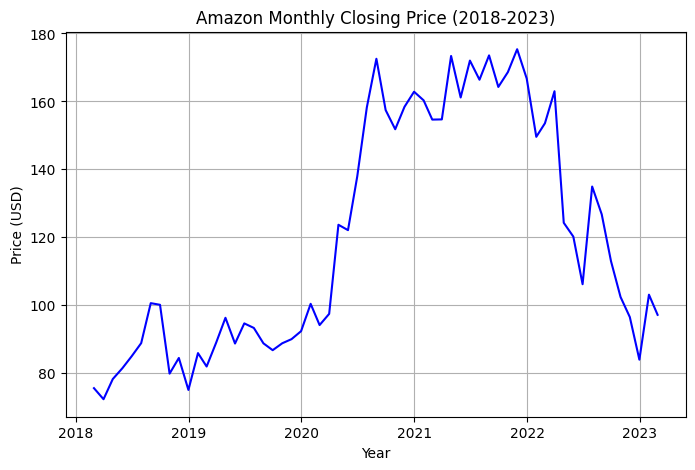

In [ ]:
#Plot Amazon Monthly Closing Price
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, color='blue')
plt.title('Amazon Monthly Closing Price (2018-2023)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()


# ADF Test for Stationary

In [ ]:
result = adfuller(monthly_close.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -1.5392301342169907
p-value: 0.5140232647833247


In [ ]:
# p-value < 0.05
# Make the Series Stationary – Log Transform and Differencing

# Log Transformation
log_close = np.log(monthly_close)
result_log = adfuller(log_close.dropna())
print("ADF Statistic (log):", result_log[0])
print("p-value (log):", result_log[1])


ADF Statistic (log): -1.6666161408109945
p-value (log): 0.4483896872175652


In [ ]:
#still p > 0.05, so the log series remains non-stationary.
#First Differencing (on Log-Transformed Data)
diff_log_close = log_close.diff().dropna()  # 1st difference of log series
result_diff_log = adfuller(diff_log_close)
print("ADF Statistic (log diff):", result_diff_log[0])
print("p-value (log diff):", result_diff_log[1])


ADF Statistic (log diff): -8.920696772064435
p-value (log diff): 1.0430561375247622e-14


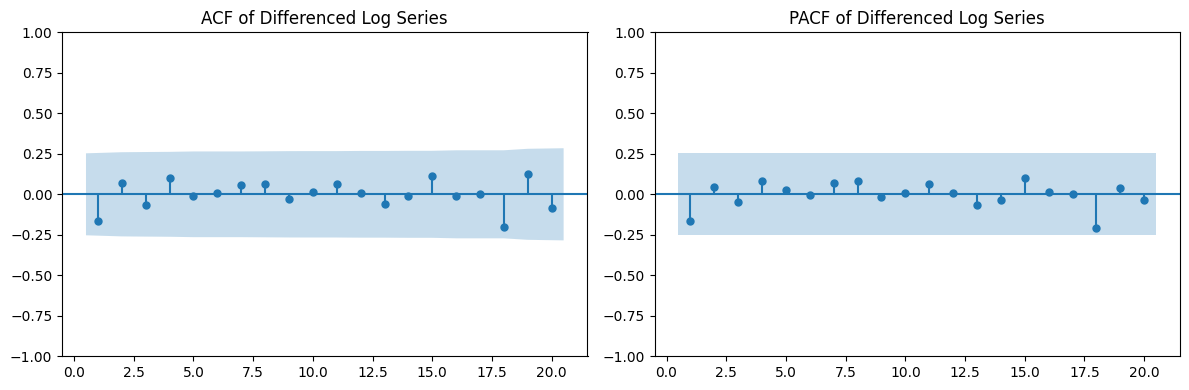

In [ ]:
#After first differencing the log series, the p-value is essentially 0 (1.0e-14),
#which is far below 0.05.now differenced log series is stationary


#Plot ACF and PACF of the Stationary Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(diff_log_close, ax=plt.gca(), lags=20, zero=False)
plt.title('ACF of Differenced Log Series')
plt.subplot(1,2,2)
plot_pacf(diff_log_close, ax=plt.gca(), lags=20, zero=False)
plt.title('PACF of Differenced Log Series')
plt.tight_layout()
plt.show()


# ARMA Model Fit (p,d,q)

In [ ]:
#Manual Grid Search for ARIMA(p,d,q) using AIC
import warnings
warnings.filterwarnings("ignore")  # ignore convergence warnings for some models
best_aic = np.inf
best_order = None
for p in range(0,10):
    for q in range(0,10):
        try:
            model = ARIMA(log_close, order=(p, 1, q))
            res = model.fit()
            print(f"ARIMA({p},1,{q}) AIC: {res.aic:.2f}")
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = (p,1,q)
        except Exception:
            continue
print(f"Best model by AIC: ARIMA{best_order} with AIC={best_aic:.2f}")


ARIMA(0,1,0) AIC: -107.97
ARIMA(0,1,1) AIC: -107.40
ARIMA(0,1,2) AIC: -105.61
ARIMA(0,1,3) AIC: -103.69
ARIMA(0,1,4) AIC: -102.42
ARIMA(0,1,5) AIC: -100.42
ARIMA(0,1,6) AIC: -98.44
ARIMA(0,1,7) AIC: -96.88
ARIMA(0,1,8) AIC: -95.09
ARIMA(0,1,9) AIC: -93.25
ARIMA(1,1,0) AIC: -107.56
ARIMA(1,1,1) AIC: -105.99
ARIMA(1,1,2) AIC: -104.02
ARIMA(1,1,3) AIC: -102.07
ARIMA(1,1,4) AIC: -100.42
ARIMA(1,1,5) AIC: -98.42
ARIMA(1,1,6) AIC: -97.01
ARIMA(1,1,7) AIC: -95.25
ARIMA(1,1,8) AIC: -93.39
ARIMA(1,1,9) AIC: -91.46
ARIMA(2,1,0) AIC: -105.73
ARIMA(2,1,1) AIC: -104.02
ARIMA(2,1,2) AIC: -102.08
ARIMA(2,1,3) AIC: -100.26
ARIMA(2,1,4) AIC: -98.83
ARIMA(2,1,5) AIC: -96.71
ARIMA(2,1,6) AIC: -97.35
ARIMA(2,1,7) AIC: -97.73
ARIMA(2,1,8) AIC: -91.28
ARIMA(2,1,9) AIC: -89.43
ARIMA(3,1,0) AIC: -103.89
ARIMA(3,1,1) AIC: -102.08
ARIMA(3,1,2) AIC: -100.20
ARIMA(3,1,3) AIC: -98.63
ARIMA(3,1,4) AIC: -96.98
ARIMA(3,1,5) AIC: -94.83
ARIMA(3,1,6) AIC: -97.85
ARIMA(3,1,7) AIC: -95.75
ARIMA(3,1,8) AIC: -89.41
ARIMA(3

In [ ]:
# Chosen ARIMA(8,1,7) model fit on the log-transformed series for best accuracy plot
model = ARIMA(log_close, order=(7, 1, 8))
results = model.fit()


In [ ]:
# Chosen ARIMA(8,1,7) model fit on the log-transformed series for best accuracy plot
model = ARIMA(log_close, order=(7, 1, 8))
results = model.fit()

# Compute In-Sample Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get in-sample predictions (log scale)
predictions = results.get_prediction(start=log_close.index[0], dynamic=False)
predicted_log = predictions.predicted_mean

# Convert to original scale and align with actual prices
predicted_prices = np.exp(predicted_log)
actual_prices = monthly_close.loc[predicted_log.index]

# Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print("\nModel Evaluation Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Model Evaluation Metrics:
MAE: $9.35
MSE: $214.73
RMSE: $14.65
MAPE: 8.53%


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(7, 1, 8)   Log Likelihood                  56.749
Date:                Thu, 10 Apr 2025   AIC                            -81.497
Time:                        18:47:59   BIC                            -47.988
Sample:                    02-28-2018   HQIC                           -68.390
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1988     10.686     -0.019      0.985     -21.143      20.745
ar.L2          0.1617      5.754      0.028      0.978     -11.116      11.439
ar.L3          0.3242      3.254      0.100      0.9

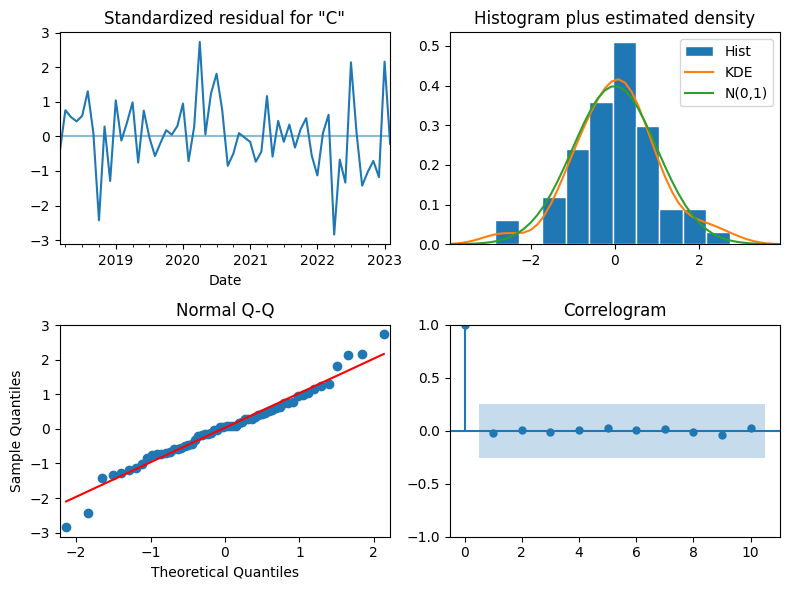

In [ ]:
#Model Summary
print(results.summary())
#Diagnostic Plots
results.plot_diagnostics(figsize=(8,6))
plt.tight_layout()
plt.show()

# Forecast the Next 24 Months

In [ ]:
# Generate forecasts for the next 24 months (in log scale)
forecast_log = results.get_forecast(steps=24)
log_forecast_mean = forecast_log.predicted_mean  # predicted log prices
log_conf_int = forecast_log.conf_int()           # confidence intervals (log scale)
print(log_forecast_mean[:5])  # print first 5 forecasted log values for example

# Convert the forecast mean and confidence interval to original scale
forecast_mean = np.exp(log_forecast_mean)  # predicted price
conf_lower = np.exp(log_conf_int.iloc[:, 0])  # lower bound of 95% CI
conf_upper = np.exp(log_conf_int.iloc[:, 1])  # upper bound of 95% CI
print(forecast_mean[:5])  # first 5 forecasted prices


2023-03-31    4.602684
2023-04-30    4.555338
2023-05-31    4.568040
2023-06-30    4.550172
2023-07-31    4.536256
Freq: ME, Name: predicted_mean, dtype: float64
2023-03-31    99.751734
2023-04-30    95.138880
2023-05-31    96.355101
2023-06-30    94.648705
2023-07-31    93.340637
Freq: ME, Name: predicted_mean, dtype: float64


# Amazon Closing Price Forecast (24 months)

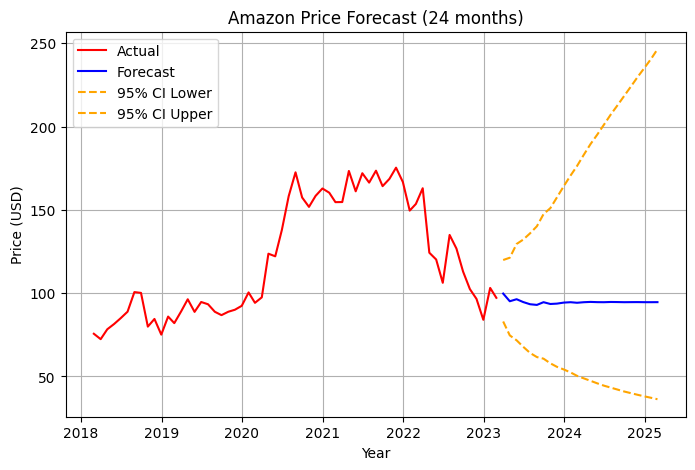

In [ ]:
#plot actual vs forecast with intervals
plt.figure(figsize=(8,5))
plt.plot(monthly_close.index, monthly_close.values, label='Actual', color='red')
plt.plot(forecast_mean.index, forecast_mean.values, label='Forecast', color='blue')
plt.plot(forecast_mean.index, conf_lower, color='orange', linestyle='--', label='95% CI Lower')
plt.plot(forecast_mean.index, conf_upper, color='orange', linestyle='--', label='95% CI Upper')
plt.title('Amazon Price Forecast (24 months)')
plt.xlabel('Year'); plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


# LSTM and GRU Models Case Study ( JJ Time Series Forecasting )

In [ ]:
# Data Loading and Preprocessing

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import matplotlib.pyplot as plt

# Load the Johnson & Johnson sales data
df = pd.read_csv('jj (2).csv', parse_dates=['date'])
df.set_index('date', inplace=True)    # set date column as index for time series
data = df['data']                     # extract the sales series

# Display basic info
print("Total observations:", len(data))
print("Start date:", data.index[0], "| End date:", data.index[-1])
print(data.head(5))  # preview the first few records

Total observations: 84
Start date: 1960-01-01 00:00:00 | End date: 1980-10-01 00:00:00
date
1960-01-01    0.71
1960-04-01    0.63
1960-07-02    0.85
1960-10-01    0.44
1961-01-01    0.61
Name: data, dtype: float64


In [ ]:
# Define train/test split
train_size = 76  # number of points in training set (1960-1978)
train = data.iloc[:train_size]
test  = data.iloc[train_size:]

# Apply log transformation to the training data
train_log = np.log(train.values)  # convert to numpy array of log values

# Apply first differencing to the log-transformed training data to obtain stationary
train_log_diff = np.diff(train_log, n=1)  # first-order difference (result length will be len(train)-1)

print("First 5 values of log(train):", train_log[:5])
print("First 5 values of diff(log(train)):", train_log_diff[:5])
print("Length of differenced log series:", len(train_log_diff))


First 5 values of log(train): [-0.34249031 -0.46203546 -0.16251893 -0.82098055 -0.49429632]
First 5 values of diff(log(train)): [-0.11954515  0.29951653 -0.65846162  0.32668423  0.12323264]
Length of differenced log series: 75


# Preparing Data for RNN Models

In [ ]:
# Prepare supervised learning sequences from the differenced log series
n_steps = 8  # window length (number of past observations to use for predicting the next one)
X_train = []
y_train = []

# Use the differenced log series (train_log_diff) to create input-output pairs
# Each X_train[i] will be a sequence of length n_steps, and y_train[i] will be the next value after that sequence.
for i in range(n_steps, len(train_log_diff)):
    X_train.append(train_log_diff[i-n_steps:i])
    y_train.append(train_log_diff[i])

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
print("Shape of X_train (samples, timesteps):", X_train.shape)
print("Shape of y_train (samples,):", y_train.shape)

# Feature scaling (normalize the differenced log data)
scaler = StandardScaler()
# Fit the scaler on the training input data (flattened) – since it's one-dimensional data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1))
# Reshape back to original X_train shape after scaling
X_train_scaled = X_train_scaled.reshape(X_train.shape)
# Also scale the y_train values using the same scaler
y_train_scaled = scaler.transform(y_train.reshape(-1, 1)).reshape(-1)

print("After scaling: mean =", X_train_scaled.mean(), ", std =", X_train_scaled.std())

# Reshape X_train for RNN input: from (samples, timesteps) to (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
print("Reshaped X_train for RNN:", X_train_scaled.shape)


Shape of X_train (samples, timesteps): (67, 8)
Shape of y_train (samples,): (67,)
After scaling: mean = -3.4798035100191475e-17 , std = 1.0
Reshaped X_train for RNN: (67, 8, 1)


# Building and Training the LSTM  and GRU Model

In [ ]:
# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='tanh', input_shape=(n_steps, 1)))  # LSTM layer
model_lstm.add(Dense(1))  # output layer for forecasting the next value
model_lstm.compile(optimizer='adam', loss='mse')

# Train the LSTM model
epochs = 100
history_lstm = model_lstm.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=16, verbose=0, shuffle=True)

print("LSTM model trained.")

# Build the GRU model
model_gru = Sequential()
model_gru.add(GRU(units=50, activation='tanh', input_shape=(n_steps, 1)))  # GRU layer
model_gru.add(Dense(1))  # output layer
model_gru.compile(optimizer='adam', loss='mse')

# Train the GRU model on the same data
history_gru = model_gru.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=16, verbose=0, shuffle=True)

print("GRU model trained.")


LSTM model trained.
GRU model trained.


In [ ]:
# Forecast horizon
n_forecast = len(test)  # number of steps to forecast (should be 8 for 2 years)

# Containers for forecasts (in original scale)
forecast_lstm = []
forecast_gru = []

# Starting window: last n_steps of training differenced log (scaled)
last_window = train_log_diff[-n_steps:]  # last 8 actual differenced log values from train
last_window_scaled = scaler.transform(last_window.reshape(-1, 1)).reshape(-1)  # scale them

# Get the last actual log value from training (to invert differencing)
last_log_value = train_log[-1]  # this is log of the last training actual data point (end of 1978)

for step in range(n_forecast):
    # Prepare input for LSTM (reshape to [1, n_steps, 1])
    X_input_lstm = np.array(last_window_scaled).reshape(1, n_steps, 1)
    # Predict the next diff (scaled) using LSTM
    pred_scaled_lstm = model_lstm.predict(X_input_lstm, verbose=0)
    # Prepare input for GRU similarly
    X_input_gru = np.array(last_window_scaled).reshape(1, n_steps, 1)
    pred_scaled_gru = model_gru.predict(X_input_gru, verbose=0)

    # Extract the scalar prediction from the arrays
    pred_scaled_value_lstm = pred_scaled_lstm[0, 0]
    pred_scaled_value_gru = pred_scaled_gru[0, 0]

    # Append the LSTM prediction to the window and drop the oldest value for next step
    last_window_scaled = np.append(last_window_scaled[1:], pred_scaled_value_lstm)
    # (Note: We're using the same window for both models for simplicity; in practice, you might maintain separate windows if needed)

    # Invert scaling to get differenced log values
    pred_diff_lstm = scaler.inverse_transform([[pred_scaled_value_lstm]])[0, 0]
    pred_diff_gru  = scaler.inverse_transform([[pred_scaled_value_gru]])[0, 0]

    # Invert differencing to get the new log value for this forecast step
    last_log_value = last_log_value + pred_diff_lstm  # update last_log_value using LSTM's prediction
    log_pred_lstm = last_log_value
    # For GRU, we need the last actual log from train for first step, and thereafter we should use GRU's own last predicted log.
    # We can manage GRU's last log separately:
    # For first forecast step, both use last_log_value from train. Let's maintain separate last_log_value for GRU:


In [ ]:
# Forecast using the LSTM model
forecast_lstm = []
last_window_scaled = scaler.transform(train_log_diff[-n_steps:].reshape(-1,1)).reshape(-1)
last_log_value = train_log[-1]  # reset last log from train for LSTM

for step in range(n_forecast):
    X_input = last_window_scaled.reshape(1, n_steps, 1)
    pred_scaled = model_lstm.predict(X_input, verbose=0)
    pred_scaled_val = pred_scaled[0, 0]
    # Update sliding window
    last_window_scaled = np.append(last_window_scaled[1:], pred_scaled_val)
    # Invert scaling and differencing
    pred_diff = scaler.inverse_transform([[pred_scaled_val]])[0, 0]
    # Compute forecasted log value and then original value
    last_log_value = last_log_value + pred_diff            # new log value
    pred_value = np.exp(last_log_value)                    # invert log to get original scale
    forecast_lstm.append(pred_value)

# Forecast using the GRU model
forecast_gru = []
last_window_scaled = scaler.transform(train_log_diff[-n_steps:].reshape(-1,1)).reshape(-1)
last_log_value = train_log[-1]  # reset last log from train for GRU

for step in range(n_forecast):
    X_input = last_window_scaled.reshape(1, n_steps, 1)
    pred_scaled = model_gru.predict(X_input, verbose=0)
    pred_scaled_val = pred_scaled[0, 0]
    # Update window
    last_window_scaled = np.append(last_window_scaled[1:], pred_scaled_val)
    # Invert scaling and differencing
    pred_diff = scaler.inverse_transform([[pred_scaled_val]])[0, 0]
    last_log_value = last_log_value + pred_diff            # update log
    pred_value = np.exp(last_log_value)                    # back to original scale
    forecast_gru.append(pred_value)

# Convert forecasts to numpy arrays for convenience
forecast_lstm = np.array(forecast_lstm)
forecast_gru = np.array(forecast_gru)

print("LSTM forecast (original scale):", forecast_lstm)
print("GRU forecast (original scale):", forecast_gru)


LSTM forecast (original scale): [12.42269859 12.87972506 12.53712661 13.61571664 15.54204193 15.74827703
 14.52819552 12.94543437]
GRU forecast (original scale): [13.24653638 12.97765572 11.69820477 12.52832443 15.00041642 15.31381916
 14.5594225  14.61727226]


In [ ]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
actual_test = test
# Convert test series to numpy array for compatibility
actual_test_values = actual_test.values

# LSTM Metrics
mae_lstm = mean_absolute_error(actual_test_values, forecast_lstm)
mse_lstm = mean_squared_error(actual_test_values, forecast_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((actual_test_values - forecast_lstm) / actual_test_values)) * 100

# GRU Metrics
mae_gru = mean_absolute_error(actual_test_values, forecast_gru)
mse_gru = mean_squared_error(actual_test_values, forecast_gru)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((actual_test_values - forecast_gru) / actual_test_values)) * 100

print("\nModel Performance Comparison:")
print(f"{'Metric':<10} {'LSTM':<15} {'GRU':<15}")
print(f"{'MAE':<10} {mae_lstm:.2f}{'':<10} {mae_gru:.2f}")
print(f"{'MSE':<10} {mse_lstm:.2f}{'':<10} {mse_gru:.2f}")
print(f"{'RMSE':<10} {rmse_lstm:.2f}{'':<10} {rmse_gru:.2f}")
print(f"{'MAPE (%)':<10} {mape_lstm:.2f}{'':<10} {mape_gru:.2f}")





Model Performance Comparison:
Metric     LSTM            GRU            
MAE        1.52           1.60
MSE        3.34           3.75
RMSE       1.83           1.94
MAPE (%)   12.03           12.40


# Johnson & Johnson Sales: Actual vs LSTM/GRU Forecasts

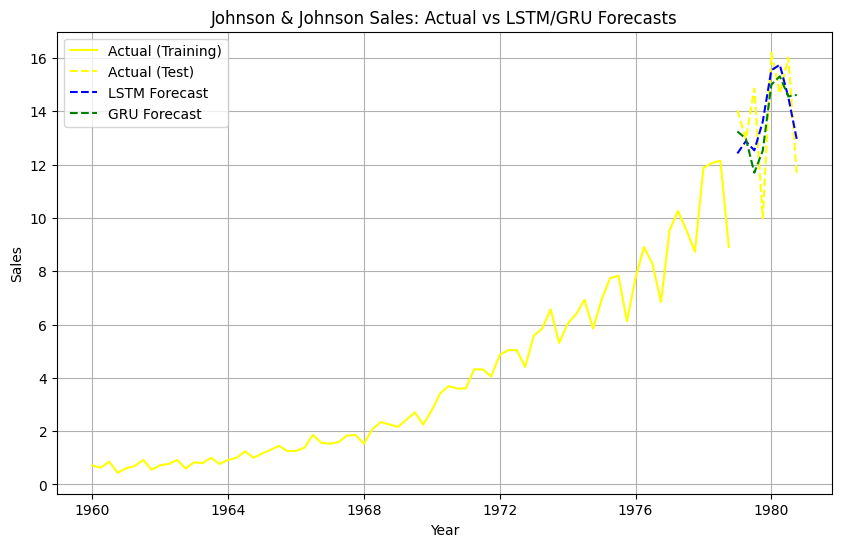

In [ ]:
# Prepare actual values for plotting
actual_train = train  # 1960-1978 actual
actual_test = test    # 1979-1980 actual (to compare with forecasts)

plt.figure(figsize=(10,6))
# Plot actual historical data
plt.plot(actual_train.index, actual_train, label='Actual (Training)', color='yellow')
plt.plot(actual_test.index, actual_test, label='Actual (Test)', color='yellow', linestyle='--')
# Plot forecasts
plt.plot(actual_test.index, forecast_lstm, label='LSTM Forecast', color='blue', linestyle='--')
plt.plot(actual_test.index, forecast_gru, label='GRU Forecast', color='green', linestyle='--')

plt.title('Johnson & Johnson Sales: Actual vs LSTM/GRU Forecasts')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


# Forecasting Amazon Stock Price with RNNs (LSTM & GRU)

In [ ]:
#Data Preparation

import pandas as pd

# Load the CSV data
df = pd.read_csv("AMZN (2).csv")
# Parse 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample to monthly frequency using the last available closing price of each month
monthly_df = df['Close'].resample('M').last()

print("Date range:", monthly_df.index.min(), "to", monthly_df.index.max())
print("Number of monthly data points:", len(monthly_df))
print(monthly_df.head(3))  # show first 3 monthly prices


Date range: 2018-02-28 00:00:00 to 2023-02-28 00:00:00
Number of monthly data points: 61
Date
2018-02-28    75.622498
2018-03-31    72.366997
2018-04-30    78.306503
Freq: ME, Name: Close, dtype: float64


In [ ]:
# Apply log transformation to the monthly closing prices
log_series = np.log(monthly_df)

# Apply first-order differencing to the log-transformed series
diff_series = log_series.diff().dropna()

# Define the split point: last 24 months for testing
train_series = monthly_df.iloc[:-24]  # all data except last 24 points
test_series  = monthly_df.iloc[-24:]  # last 24 months for test

# Differenced log series for the training period and testing period
train_diff = diff_series[:train_series.index.max()]  # up to Feb 2021 diff
test_diff  = diff_series[test_series.index.min():]   # from Mar 2021 diff onward

In [ ]:
window_size = 12
train_diff_values = train_diff.values  # numpy array of training differenced log values

X = []
y = []
# Sliding window: use past 12 values to predict the next value
for i in range(window_size, len(train_diff_values)):
    X.append(train_diff_values[i-window_size:i])  # 12 values
    y.append(train_diff_values[i])               # next value

X = np.array(X)
y = np.array(y)
print("Shape of X (samples, timesteps):", X.shape)
print("Shape of y (samples,):", y.shape)


Shape of X (samples, timesteps): (24, 12)
Shape of y (samples,): (24,)


In [ ]:
#Data Preparation

import pandas as pd
import numpy as np  # Import numpy

# Load the CSV data
df = pd.read_csv("AMZN (2).csv")
# Parse 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample to monthly frequency using the last available closing price of each month
monthly_df = df['Close'].resample('M').last()

print("Date range:", monthly_df.index.min(), "to", monthly_df.index.max())
print("Number of monthly data points:", len(monthly_df))
print(monthly_df.head(3))  # show first 3 monthly prices

# Apply log transformation to the monthly closing prices
log_series = np.log(monthly_df)

# Apply first-order differencing to the log-transformed series
diff_series = log_series.diff().dropna()

# Define the split point: last 24 months for testing
train_series = monthly_df.iloc[:-24]  # all data except last 24 points
test_series  = monthly_df.iloc[-24:]  # last 24 months for test

# Differenced log series for the training period and testing period
train_diff = diff_series[:train_series.index.max()]  # up to Feb 2021 diff
test_diff  = diff_series[test_series.index.min():]   # from Mar 2021 diff onward

window_size = 12
train_diff_values = train_diff.values  # numpy array of training differenced log values

X = []
y = []
# Sliding window: use past 12 values to predict the next value
for i in range(window_size, len(train_diff_values)):
    X.append(train_diff_values[i-window_size:i])  # 12 values
    y.append(train_diff_values[i])               # next value

X = np.array(X)
y = np.array(y)
print("Shape of X (samples, timesteps):", X.shape)
print("Shape of y (samples,):", y.shape)

from sklearn.preprocessing import StandardScaler

# Initialize scaler and fit on training differenced values (reshaped to column vector)
scaler = StandardScaler()
scaler.fit(train_diff_values.reshape(-1, 1))

# Transform the input sequences and target values
X_scaled = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)
y_scaled = scaler.transform(y.reshape(-1, 1)).flatten()


X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))
print("Reshaped X_scaled for RNN input:", X_scaled.shape)

Date range: 2018-02-28 00:00:00 to 2023-02-28 00:00:00
Number of monthly data points: 61
Date
2018-02-28    75.622498
2018-03-31    72.366997
2018-04-30    78.306503
Freq: ME, Name: Close, dtype: float64
Shape of X (samples, timesteps): (24, 12)
Shape of y (samples,): (24,)
Reshaped X_scaled for RNN input: (24, 12, 1)


# Feature Scaling

# Building and Training the RNN Models (LSTM & GRU)

In [ ]:
#Building and Training the RNN Models
# Set random seeds for reproducibility
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Build GRU model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train both models for a fixed number of epochs
epochs = 100
history_lstm = lstm_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)
history_gru  = gru_model.fit(X_scaled, y_scaled, epochs=epochs, verbose=0)

# Print final training losses
print("LSTM final training loss:", history_lstm.history['loss'][-1])
print("GRU final training loss:", history_gru.history['loss'][-1])


LSTM final training loss: 0.2899162471294403
GRU final training loss: 0.24875783920288086


# Forecasting the Next 24 Months

In [ ]:
# Prepare for forecasting
forecast_horizon = 24
last_log = log_series[train_series.index.max()]  # last known log price from training period (Feb 2021)
last_12_diffs = train_diff[-12:].values          # last 12 actual log-differences up to Feb 2021

# Forecast with LSTM
predictions_lstm = []
for step in range(forecast_horizon):
    # Scale the last 12 differences to feed into model
    input_seq = scaler.transform(last_12_diffs.reshape(-1,1)).reshape(1, window_size, 1)
    # Predict next difference (scaled) and invert scaling
    pred_scaled_diff = lstm_model.predict(input_seq, verbose=0)
    pred_diff = scaler.inverse_transform(pred_scaled_diff)[0, 0]
    # Compute predicted new log price and then actual price
    new_log = last_log + pred_diff
    new_price = np.exp(new_log)
    predictions_lstm.append(new_price)
    # Update state for next iteration
    last_log = new_log
    # update the diff window: drop oldest diff, append the new diff
    last_12_diffs = np.concatenate([last_12_diffs[1:], [pred_diff]])

# Reset for GRU forecasting
last_log = log_series[train_series.index.max()]  # reset last known log price
last_12_diffs = train_diff[-12:].values.copy()

predictions_gru = []
for step in range(forecast_horizon):
    input_seq = scaler.transform(last_12_diffs.reshape(-1,1)).reshape(1, window_size, 1)
    pred_scaled_diff = gru_model.predict(input_seq, verbose=0)
    pred_diff = scaler.inverse_transform(pred_scaled_diff)[0, 0]
    new_log = last_log + pred_diff
    new_price = np.exp(new_log)
    predictions_gru.append(new_price)
    last_log = new_log
    last_12_diffs = np.concatenate([last_12_diffs[1:], [pred_diff]])

# Convert predictions lists to Pandas series with proper dates
forecast_index = test_series.index  # dates for Mar 2021 to Feb 2023
pred_series_lstm = pd.Series(predictions_lstm, index=forecast_index)
pred_series_gru  = pd.Series(predictions_gru, index=forecast_index)

print(pred_series_lstm.head(3))
print(pred_series_gru.head(3))
print("Actual vs Predicted (first 3 months of test):")
for date in forecast_index[:3]:
    actual = test_series.loc[date]
    lstm_pred = pred_series_lstm.loc[date]
    gru_pred  = pred_series_gru.loc[date]
    print(f"{date:%Y-%m}: Actual={actual:.2f}, LSTM={lstm_pred:.2f}, GRU={gru_pred:.2f}")

Date
2021-03-31    156.080128
2021-04-30    154.513836
2021-05-31    163.067793
Freq: ME, dtype: float64
Date
2021-03-31    158.256804
2021-04-30    164.123682
2021-05-31    170.032602
Freq: ME, dtype: float64
Actual vs Predicted (first 3 months of test):
2021-03: Actual=154.70, LSTM=156.08, GRU=158.26
2021-04: Actual=173.37, LSTM=154.51, GRU=164.12
2021-05: Actual=161.15, LSTM=163.07, GRU=170.03


In [ ]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert test series to numpy array for compatibility
actual_prices = test_series.values
lstm_predictions = pred_series_lstm.values
gru_predictions = pred_series_gru.values

# LSTM Metrics
mae_lstm = mean_absolute_error(actual_prices, lstm_predictions)
mse_lstm = mean_squared_error(actual_prices, lstm_predictions)
rmse_lstm = np.sqrt(mse_lstm)
mape_lstm = np.mean(np.abs((actual_prices - lstm_predictions) / actual_prices)) * 100

# GRU Metrics
mae_gru = mean_absolute_error(actual_prices, gru_predictions)
mse_gru = mean_squared_error(actual_prices, gru_predictions)
rmse_gru = np.sqrt(mse_gru)
mape_gru = np.mean(np.abs((actual_prices - gru_predictions) / actual_prices)) * 100

print("\nModel Performance Comparison:")
print(f"{'Metric':<10} {'LSTM':<15} {'GRU':<15}")
print(f"{'MAE':<10} ${mae_lstm:.2f}{'':<8} ${mae_gru:.2f}")
print(f"{'MSE':<10} ${mse_lstm:.2f}{'':<8} ${mse_gru:.2f}")
print(f"{'RMSE':<10} ${rmse_lstm:.2f}{'':<8} ${rmse_gru:.2f}")
print(f"{'MAPE (%)':<10} {mape_lstm:.2f}%{'':<6} {mape_gru:.2f}%")


Model Performance Comparison:
Metric     LSTM            GRU            
MAE        $147.56         $115.49
MSE        $35391.60         $23235.48
RMSE       $188.13         $152.43
MAPE (%)   129.84%       104.25%


# Historical vs Forecasted stock close prices for both LSTM and GRU

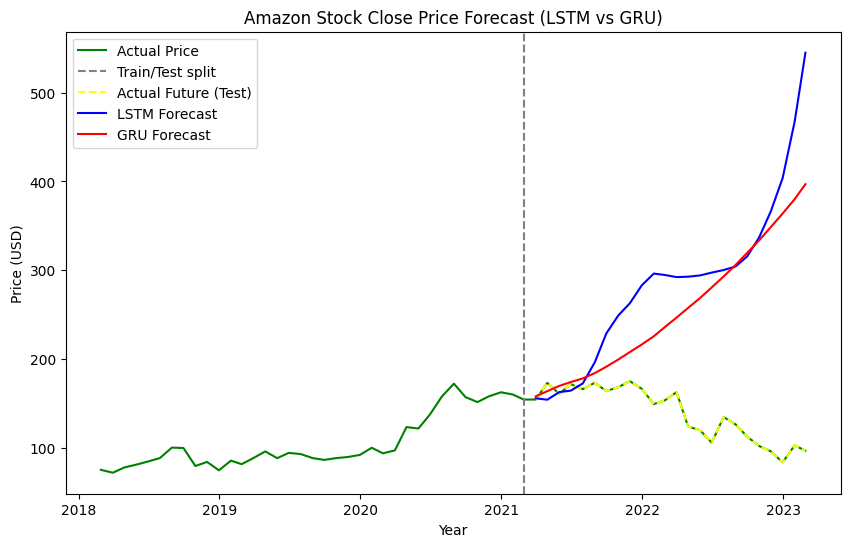

In [ ]:
# Plot Amazon Stock Close Price Forecast (LSTM vs GRU)
plt.figure(figsize=(10,6))
plt.plot(monthly_df.index, monthly_df.values, label='Actual Price', color='green')
plt.axvline(x=train_series.index[-1], color='gray', linestyle='--', label='Train/Test split')
plt.plot(test_series.index, test_series.values, label='Actual Future (Test)', color='yellow', linestyle='--')
plt.plot(pred_series_lstm.index, pred_series_lstm.values, label='LSTM Forecast', color='blue')
plt.plot(pred_series_gru.index, pred_series_gru.values, label='GRU Forecast', color='red')
plt.title('Amazon Stock Close Price Forecast (LSTM vs GRU)')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()
